# Dollar bars vs Volume bars Sunny
Purpose: To determine whether we should use dollar bars or volume bars for the rest of this project. First, we will find metrics that are important, then find out how to implement them, then come to a conclusion on which bars perform the best. 

Helpful resources:
- https://towardsdatascience.com/advanced-candlesticks-for-machine-learning-ii-volume-and-dollar-bars-6cda27e3201d
- Advances in Financial Machine Learning from 2.3.1 to 2.3.2

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.stattools as sm
from scipy import stats

In [2]:
db = pd.read_csv("../data/BTCUSDT-dollar-bars.csv")
vb = pd.read_csv("../data/BTCUSDT-volume-bars.csv")
tb = pd.read_csv("../data/discarded/BTCUSDT-minute-target-ui.csv")

In [40]:
rb = np.random.uniform(1, 60000, 1_000_000) #Random bars

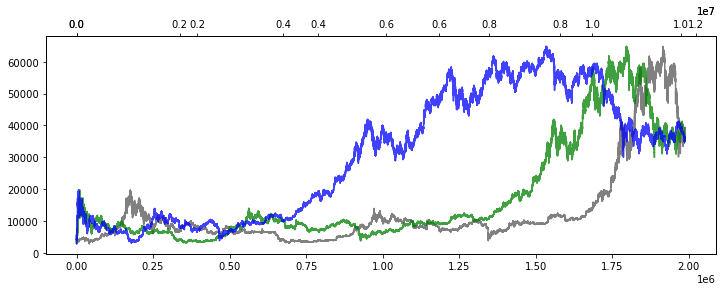

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(tb.close, color="gray")
ax1 = ax.twiny()
ax1.plot(vb.close, color="green", alpha=.75)
ax2 = ax.twiny()
ax2.plot(db.close, color="blue", alpha=.75);


## Serial Correlation/ auto-correlation

In [57]:
def returns(candles_close_prices):
    return np.diff(np.log(candles_close_prices))
def non_log_returns(candles_close_prices):
    return np.diff(candles_close_prices)

In [58]:
db_nlr = non_log_returns(db.close)
vb_nlr = non_log_returns(vb.close)
tb_nlr = non_log_returns(tb.close)

In [43]:
db_sc = returns(db.close)
vb_sc = returns(vb.close)
tb_sc = returns(tb.close)
rb_sc = returns(rb)

In [45]:
np.mean(vb_sc)

1.8038338856252555e-07

In [53]:
sm.durbin_watson(tb_sc)

2.1381491972397275

In [54]:
sm.durbin_watson(vb_sc)

2.323736309255039

In [55]:
sm.durbin_watson(db_sc)

2.1909464460628354

In [66]:
corr, _ = pearsonr(tb_sc[:-1], tb_sc[1:])
corr

-0.06907541053093148

In [67]:
corr, _ = pearsonr(vb_sc[:-1], vb_sc[1:])
corr

-0.16186826879553662

In [68]:
corr, _ = pearsonr(db_sc[:-1], db_sc[1:])
corr

-0.09547390759127078

## Downsampling
Reasoning: Ver few bars for time series, more for dollar, and even more for volume bars. Need equal amounts

In [3]:
def downsample_to_proportion(rows, proportion):

    counter = 0.0
    last_counter = None
    results = []

    for row in rows:

        counter += proportion

        if int(counter) != last_counter:
            results.append(row)
            last_counter = int(counter)

    return results

In [4]:
downsample_to_proportion([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 0.5)

[1, 2, 4, 6, 8, 10]

In [5]:
tb_ds = downsample_to_proportion(tb.close, 1_000_000/len(tb))
vb_ds = downsample_to_proportion(vb.close, 1_000_000/len(vb))
db_ds = downsample_to_proportion(db.close, 1_000_000/len(db))

In [8]:
db_sc = returns(db_ds)
vb_sc = returns(vb_ds)
tb_sc = returns(tb_ds)
print(f"dollor bars: {np.mean(db_sc)}")
print(f"volume bars: {np.mean(vb_sc)}")
print(f"time bars: {np.mean(tb_sc)}")

dollor bars: 2.1206878737648934e-06
volume bars: 2.128316363757566e-06
time bars: 2.206236260457425e-06


In [9]:
corr, _ = stats.pearsonr(db_sc[:-1], db_sc[1:])
print(f"dollor bars: {corr}")
corr, _ = stats.pearsonr(vb_sc[:-1], vb_sc[1:])
print(f"volume bars: {corr}")
corr, _ = stats.pearsonr(tb_sc[:-1], tb_sc[1:])
print(f"time bars: {corr}")

dollor bars: -0.005919938106342808
volume bars: -0.011168987807684718
time bars: -0.07398555090077386


In [10]:
# Result: Both dollar and volume bars much better than time bars, 
# but dollar still twice as good as volume bars

In [11]:
corr = sm.durbin_watson(db_sc)
print(f"dollor bars: {corr}")
corr = sm.durbin_watson(vb_sc)
print(f"volume bars: {corr}")
corr = sm.durbin_watson(tb_sc)
print(f"time bars: {corr}")

dollor bars: 2.011403632993851
volume bars: 2.022324967360494
time bars: 2.1479681145041085


In [12]:
# Result: Both dollar and volume bars much better than time bars again, 
# this time as well, dollar bars pull ahead

## Normality of returns (seemingly bad?)

In [14]:
corr = stats.jarque_bera(db_sc)
print(f"dollor bars: {corr}")
corr = stats.jarque_bera(vb_sc)
print(f"volume bars: {corr}")
corr = stats.jarque_bera(tb_sc)
print(f"time bars: {corr}")

dollor bars: Jarque_beraResult(statistic=608600829.6121857, pvalue=0.0)
volume bars: Jarque_beraResult(statistic=273376245.1795906, pvalue=0.0)
time bars: Jarque_beraResult(statistic=392431638.35621816, pvalue=0.0)


In [16]:
# Results: p-value is 0.00, therefore does not follow a gaussian distribution
# If statistic is far from zero, it signals the data do not have a normal distribution.

## Volume growth

Text(0, 0.5, 'BTC volume')

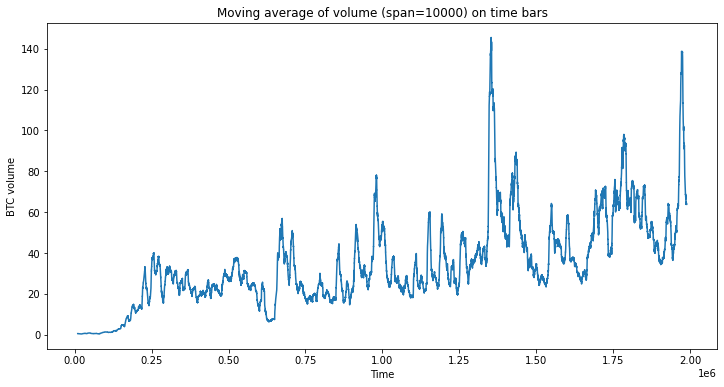

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(tb.volume.rolling(window=10000).mean())

ax.set_title("Moving average of volume (span=10000) on time bars")
ax.set_xlabel("Time")
ax.set_ylabel("BTC volume")

In [30]:
# Seems like volume is growing despite price of bitcoin

## Argument for volume bars over time bars

Exerpt discussing why time bars are bad: 

>This means that time bars oversample information during low-activity periods and undersample information during high-activity periods. Second, time-sampled series often exhibit poor statistical properties, like serial correlation, heteroscedasticity, and non-normality of returns 

Volume bars correct for this, but dollar bars seeminly over correct for this due to rising in price of bitcoin and rising volume such that the past 6 months account for over half of all the volume bars



In [60]:
stats.normaltest(vb_nlr)

NormaltestResult(statistic=6832535.870972994, pvalue=0.0)

(array([ 14936.,  18482.,  30606.,  43235., 114069., 795940.,  35343.,
         24392.,  16730.,  13317.]),
 array([-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
         0.08,  0.1 ]),
 <BarContainer object of 10 artists>)

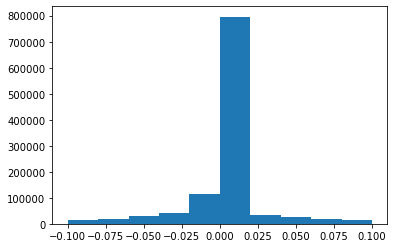

In [61]:
plt.hist(db_nlr, range=[-0.1, 0.1])

In [53]:
min(vb_sc)

-0.09520322221290733